# CSYS5040 Tutorial for time-series analysis of resting-state fMRI data

### Annie Bryant
### 17 September 2024

In [1]:
# Install required packages if needed
!pip install pycatch22 pyspi numpy pandas seaborn matplotlib rpy2

# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycatch22
from pyspi.calculator import Calculator
import seaborn as sns
from copy import deepcopy
import requests
import io
from matplotlib.lines import Line2D
import warnings
from matplotlib import cm

In [2]:
# Load in the example fMRI time-series data
response = requests.get('https://github.com/anniegbryant/CSYS5040_Demo/raw/main/fMRI_resting_data.npy')
response.raise_for_status() # Check that the request was successful

# Load the .npy content into a numpy array
file_data = io.BytesIO(response.content)
fMRI_resting_data = np.load(file_data, allow_pickle=True)


In [3]:
# info about example_array.npy
# Sample_ID: Train_1
# cortical: negativity

# Load in the example EEG time-series data
fMRI_resting_data = np.load('fMRI_resting_data.npy')

# The 7 rows represent seven resting-state networks of brain activity, while the 947 coumns represent timepoints
# Let's print the first five rows (brain networks) and columns (timepoints) of the resting-state fMRI time-series data
print(fMRI_resting_data[0:5, 0:5])

[[-0.95429605 -0.96895107 -0.47352705 -0.58280167 -0.22510818]
 [-1.37612159 -0.61024501 -0.33130259  1.9982668   1.23660763]
 [ 2.12000844  1.83853096 -0.1088877   1.60167371  1.42746935]
 [-0.49252915  0.95369168 -0.12480374  3.15599038  2.57502518]
 [ 1.42835683  1.27789451  0.50976466 -0.98587253 -1.19162177]]


## Visualizing brain networks

![Image of 7 Yeo resting-state networks](https://github.com/anniegbryant/CSYS5040_Demo/blob/main/Yeo7_Networks.png?raw=true)

In [4]:
# Let's convert this to a Pandas DataFrame for easier manipulation
fMRI_resting_data_df = pd.DataFrame(fMRI_resting_data)

# Define networks
brain_networks = ["Control", "Default", "DorsalAttention", "Limbic", "Somatomotor", "VentralAttention", "Visual"]

# Assign column for networks
fMRI_resting_data_df['Brain_Network'] = brain_networks

# Pivot from wide to long
fMRI_resting_data_df = fMRI_resting_data_df.melt(id_vars='Brain_Network', var_name='Timepoint', value_name='Signal')
fMRI_resting_data_df.head()

,Brain_Network,Timepoint,Signal
0,Control,0,-0.954296
1,Default,0,-1.376122
2,DorsalAttention,0,2.120008
3,Limbic,0,-0.492529
4,Somatomotor,0,1.428357


Text(0, 0.5, 'BOLD Signal')

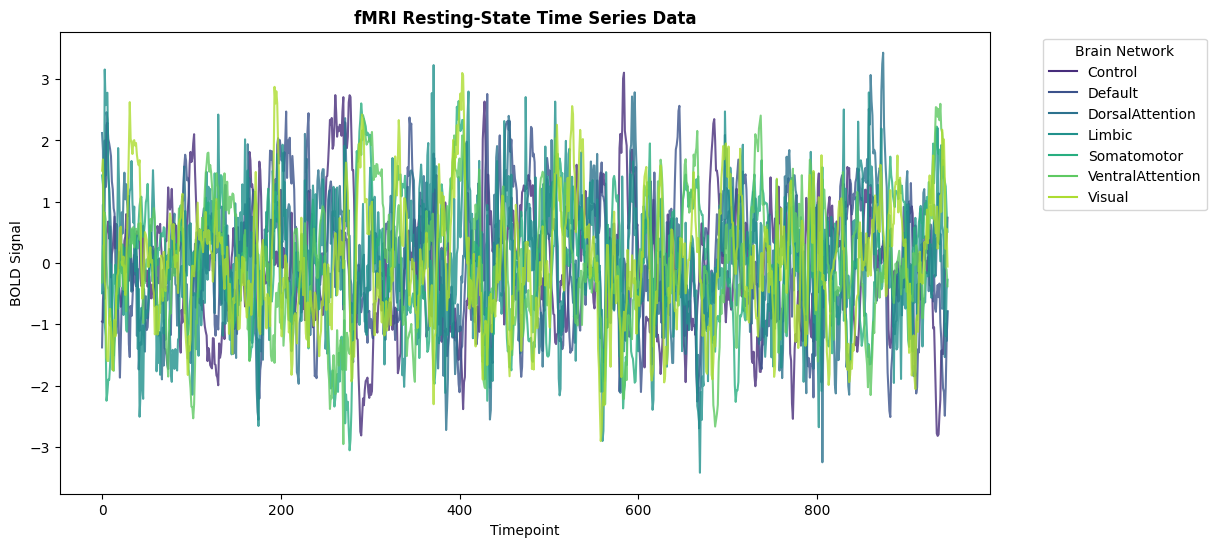

In [5]:
# Visualize the time series as line plots with a Viridis color palette
plt.figure(figsize=(12, 6))
sns.lineplot(data=fMRI_resting_data_df, x='Timepoint', y='Signal', hue='Brain_Network', palette='viridis', alpha=0.8)

# Set title
plt.title('fMRI Resting-State Time Series Data', fontweight='bold')

# Put legend on outside with two columns
plt.legend(title='Brain Network', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x and y axis titles
plt.xlabel('Timepoint')
plt.ylabel('BOLD Signal')

Text(120.72222222222221, 0.5, 'Brain Network')

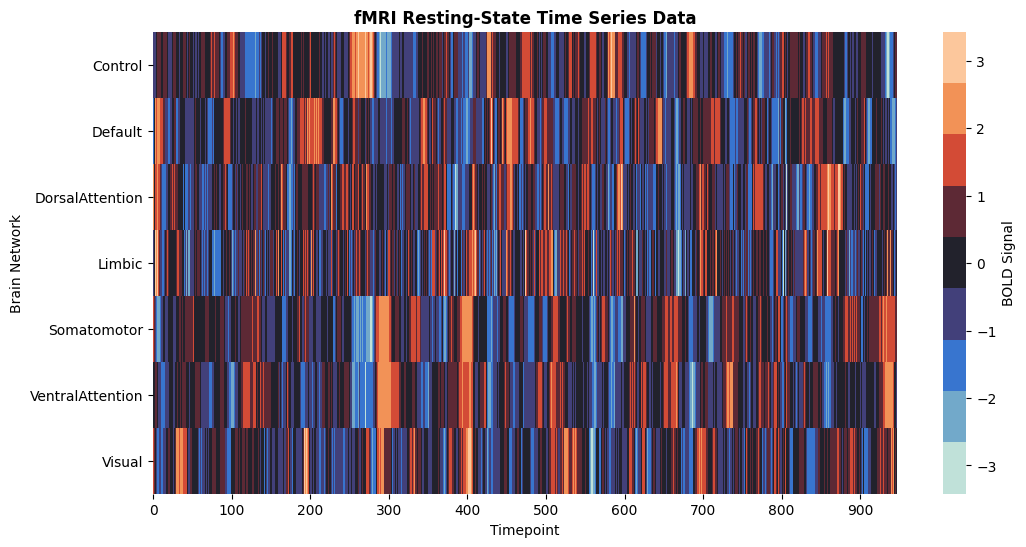

In [6]:
# Plot as a MTS heatmap
plt.figure(figsize=(12, 6))
# Create an array with the colors you want to use
colors = ["#C0E1D9", "#72A9CA", "#3875CF", "#42407A", "#22222C", "#5D2935", "#D34B36", "#F29257", "#FCC79C"]
sns.heatmap(fMRI_resting_data, cmap=sns.color_palette(colors), xticklabels=100, cbar_kws={'label': 'BOLD Signal'})
plt.title('fMRI Resting-State Time Series Data', fontweight='bold')
# Set y-axis text to the brain networks
plt.yticks(ticks=np.arange(0.5, 7.5, 1), labels=["Control", "Default", "DorsalAttention", "Limbic", "Somatomotor", "VentralAttention", "Visual"], rotation=0)
plt.xlabel('Timepoint')
plt.ylabel('Brain Network')

### Univariate time-series feature analysis with catch22

Let's get to extracting time-series features! For univariate dynamics, we will look at the catch22 feature set that we covered in the lecture.

In [7]:
# Compute catch22 features for each row of fMRI_resting_data
fMRI_resting_catch22_res = np.apply_along_axis(pycatch22.catch22_all, 1, fMRI_resting_data, short_names=True)
fMRI_resting_catch22_res_list = []

# Iterate over each network and extract the catch22 features into a dataframe
for network_index in range(7):
    brain_network = brain_networks[network_index]
    catch22_features = fMRI_resting_catch22_res[network_index]
    network_catch22_df = (pd.DataFrame(catch22_features)
                          .assign(Brain_Network=brain_network)
                          .rename(columns={"short_names": "catch22_feature", "values": "feature_value"})
                          .drop(columns='names'))

    # Append to list
    fMRI_resting_catch22_res_list.append(network_catch22_df)

# Concatenate the list of DataFrames into a single DataFrame
fMRI_resting_catch22_df = pd.concat(fMRI_resting_catch22_res_list)

# Let's print the first few rows of the catch22 features DataFrame
fMRI_resting_catch22_df.head()

,catch22_feature,feature_value,Brain_Network
0,mode_5,0.142363,Control
1,mode_10,-0.153780,Control
2,acf_timescale,6.687898,Control
3,acf_first_min,29.000000,Control
4,ami2,0.382284,Control


Now that we have extracted our catch22 features for each of the seven fMRI brain networks, let's look at the value of each feature per network:

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_38284/2617020498.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


<Figure size 800x400 with 0 Axes>

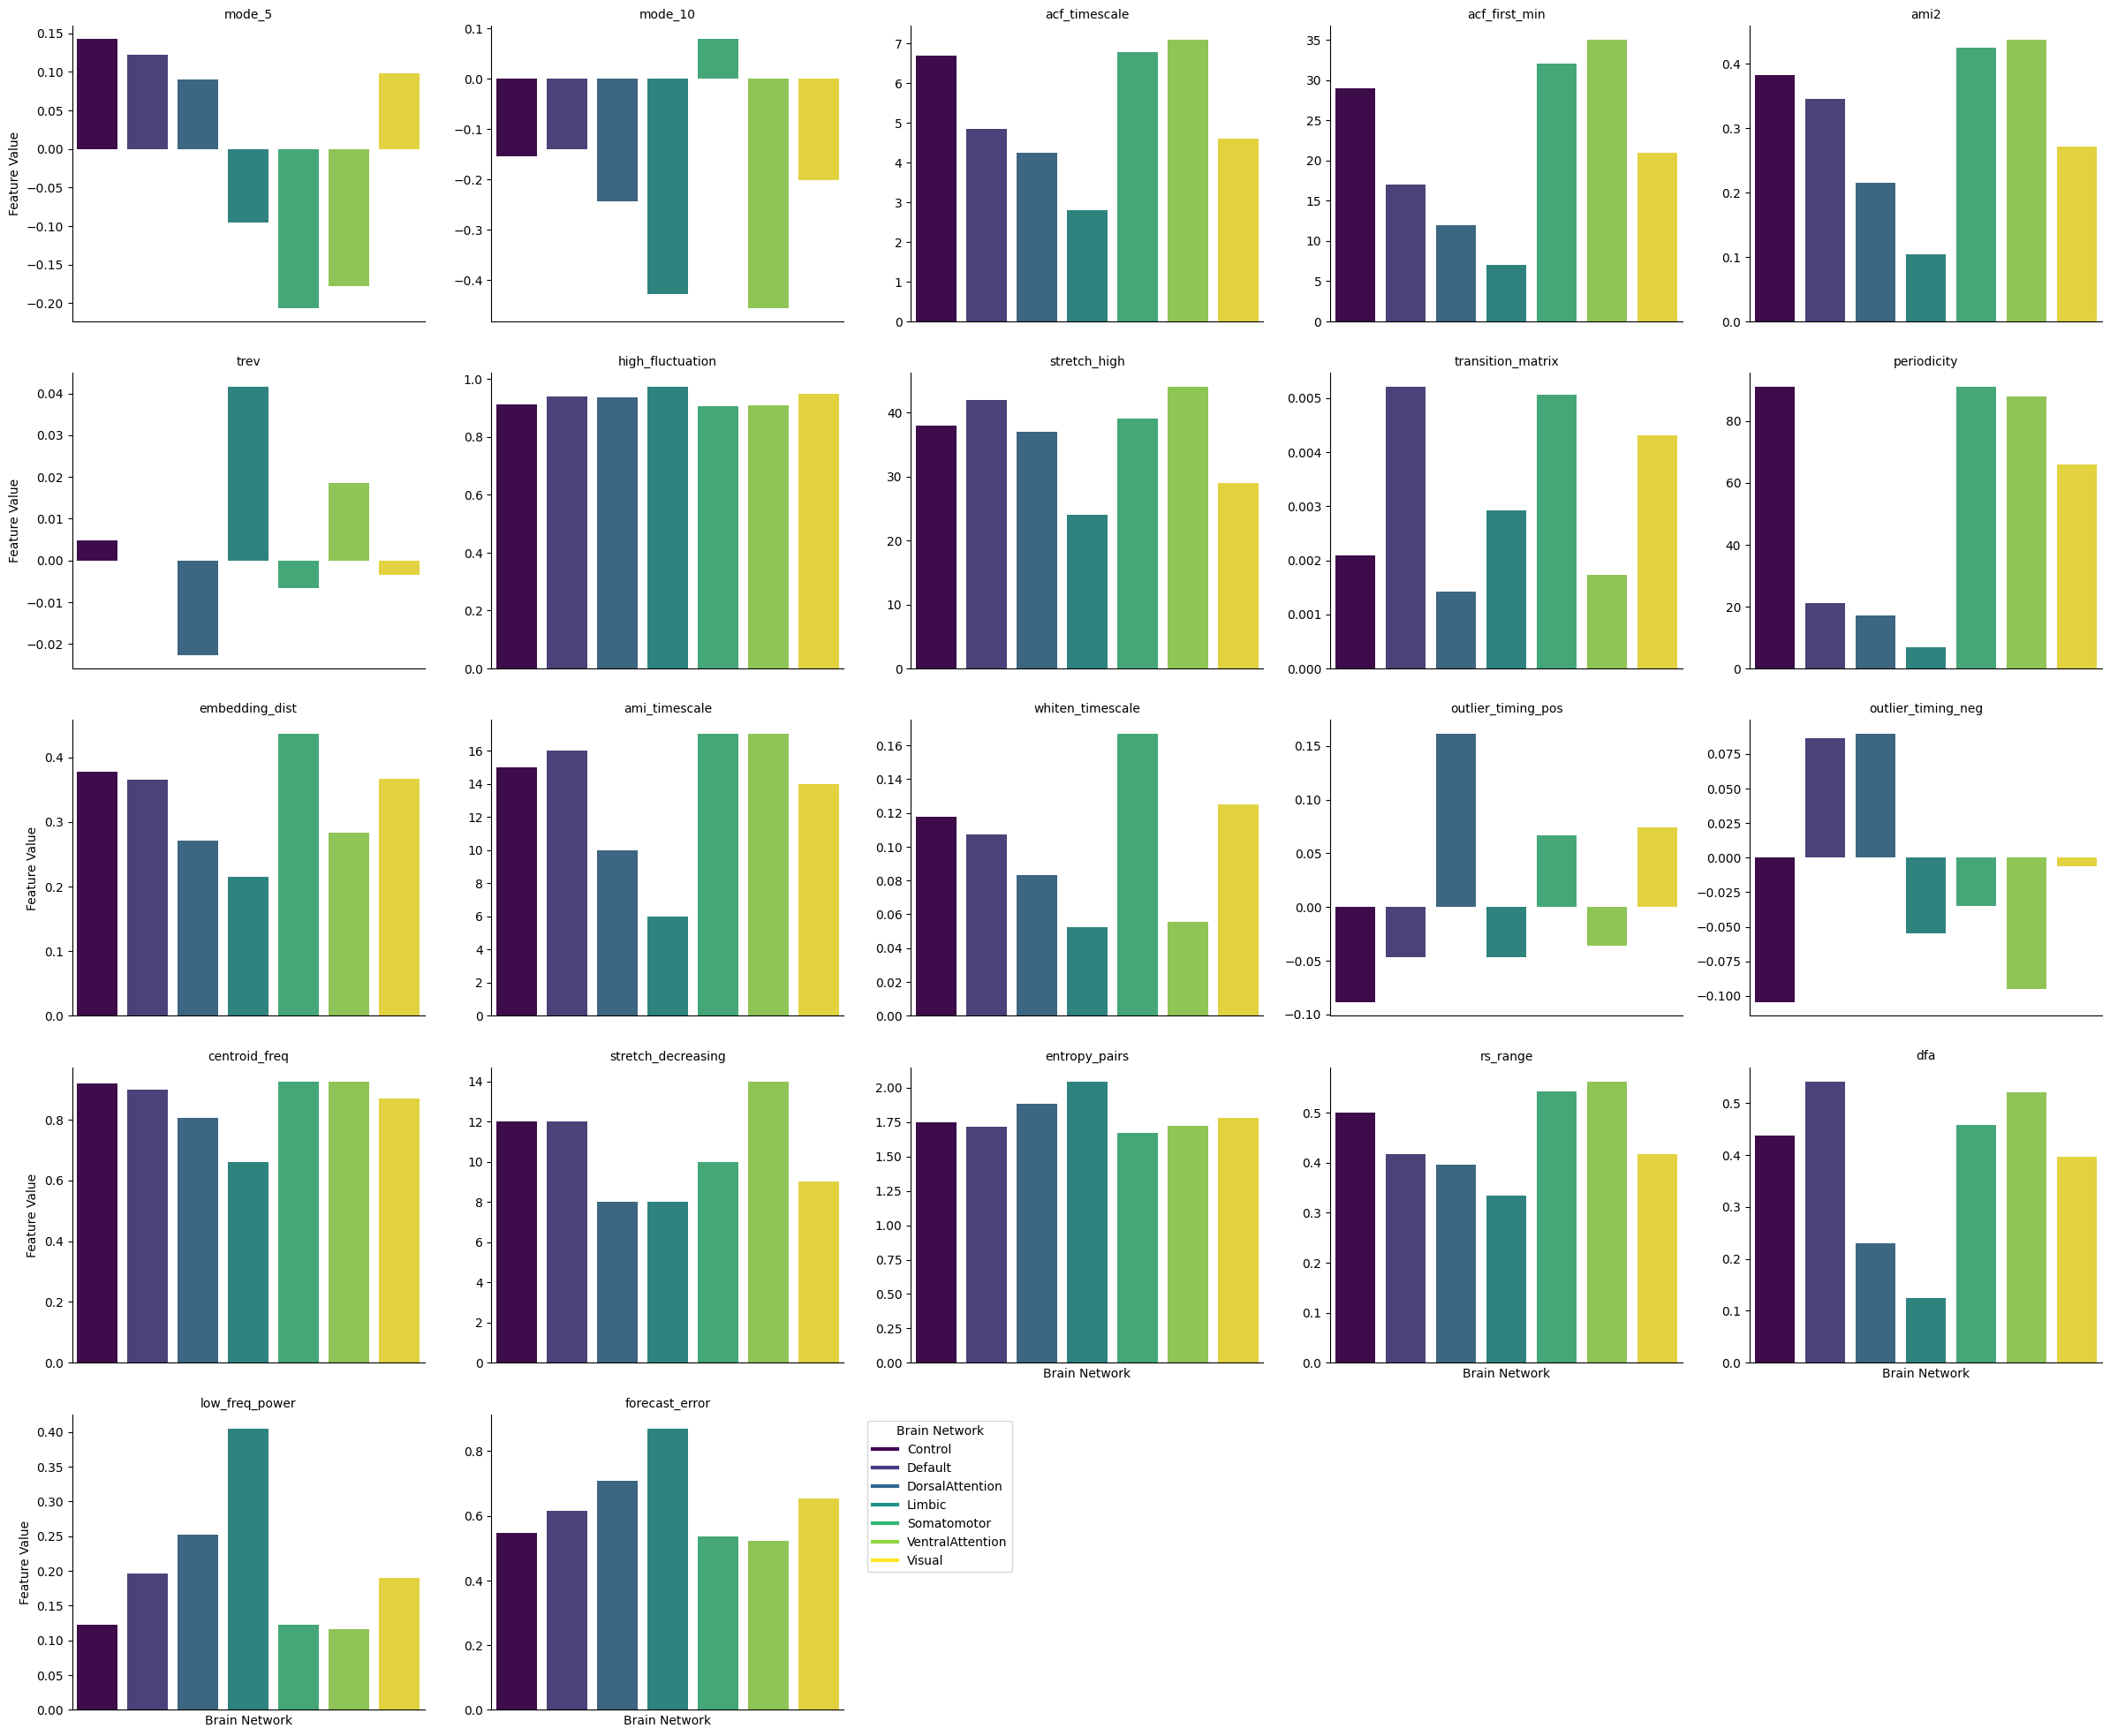

In [8]:
# Set the figure size
warnings.filterwarnings("ignore", message="iteritems is deprecated and will be removed in a future version")
plt.figure(figsize=(8, 4))

# Set the color palette to viridis
cmap = cm.get_cmap("viridis")
 # Divide by 6 to sample the full range including the yellow end
colors = [cmap(i / 6) for i in range(7)] 

# Plot the bar plots with facet grid
g = sns.FacetGrid(fMRI_resting_catch22_df, col='catch22_feature', col_wrap=5, height=4, aspect=1.2, sharey=False)
g.map(sns.barplot, 'Brain_Network', 'feature_value', palette=colors, order=brain_networks)

# Set the x-axis label
g.set_axis_labels('Brain Network', 'Feature Value')

# Set the title for each facet
g.set_titles('{col_name}')

# Increase axis labels font size
g.set_axis_labels(fontsize=16)

# Increase facet titles font size
g.set_titles(size=16)
g.set_titles(row_template='{row_name}', col_template='{col_name}')

# Hide x-axis labels for all plots
g.set_xticklabels([], rotation=90)
# Hide ticks from the x-axis for all plots
g.set(xticks=[])

# Add legend
plt.legend([Line2D([0], [0], color=c, linewidth=3) for c in colors], brain_networks, title='Brain Network', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

### Bivariate time-series feature analysis with pyspi

Having completed our analysis of local univariate time-series features, now let's examine statistics of pairwise interactions (SPIs) between each pair of brain networks using pyspi! We will use a reduced subset of 14 SPIs for the sake of time in this lab, but the procedure applies to the full analysis pipeline with 284 SPIs.

In [9]:
# Read in relevant information about the SPIs
response = requests.get("https://raw.githubusercontent.com/anniegbryant/CSYS5040_Demo/main/pairwise_feature_info.csv")
response.raise_for_status() # Check that the request was successful

# Load the .npy content into a numpy array
file_data = io.BytesIO(response.content)
SPI_info = pd.read_csv(file_data)

# Print out our SPI info
SPI_info

,Figure_name,pyspi_name,Literature_Category,Directed,Feature_description,Module
0,PSI_frequency,psi_multitaper_mean_fs-1_fmin-0_fmax-0-5,Spectral,Yes,Phase slope index that measures information fl...,1
1,ANM,anm,Causal inference,Yes,Additive noise model that tests for directed n...,2
2,DI,di_gaussian,Information theory,Yes,Directed information which measures informatio...,3
3,transfer_entropy,te_kraskov_NN-4_DCE_k-max-10_tau-max-4,Information theory,Yes,Transfer entropy which captures information tr...,4
4,phi_star,phi_star_t-1_norm-0,Information theory,No,Integrated information proxy that measures the...,5
5,spectral_GC,sgc_nonparametric_mean_fs-1_fmin-0_fmax-0-5,Spectral,Yes,Spectral Granger Causality -- which is the fre...,6
6,PLI,pli_multitaper_max_fs-1_fmin-0_fmax-0-5,Spectral,Yes,Phase lag index which averages the sign of the...,7
7,PSI_time_frequency,psi_wavelet_mean_fs-1_fmin-0_fmax-0-5_mean,Spectral,Yes,Phase slope index that measures information fl...,8
8,barycenter_DTW,bary_dtw_mean,Distance statistics,No,Barycenter aka univariate time-series that min...,9
9,DTW,dtw_constraint-itakura,Distance statistics,No,Minimum distance between potentially dilated t...,10


Here we see a list of 14 SPIs (we'll use the `Figure_name` column which contains shorthand names for each SPI) that includes their literature category (e.g., Basic statistics, Spectral), whether they are directed or undirected, and a basic description of what the feature measures.

Now we will initialize a `Calculator` object with this reduced subset of SPIs (with `subset='sonnet'`) and compute the features for each pair of brain networks.

In [ ]:
# Initialize a Calculator object
calc = Calculator(subset='sonnet', dataset=fMRI_resting_data)
calc.compute()

# Save SPI results 
SPI_res = deepcopy(calc.table)

# Iterate over each SPI
SPI_res.columns = SPI_res.columns.to_flat_index()

# Convert index to column
SPI_res.reset_index(level=0, inplace=True)

# Rename index as first brain region
SPI_res = SPI_res.rename(columns={"index": "network_from"})


In [14]:
SPI_res_long.head()

,network_from,variable,value
0,proc-0,"(cov_EmpiricalCovariance, proc-0)",NaN
1,proc-1,"(cov_EmpiricalCovariance, proc-0)",0.215185
2,proc-2,"(cov_EmpiricalCovariance, proc-0)",-0.035829
3,proc-3,"(cov_EmpiricalCovariance, proc-0)",-0.209136
4,proc-4,"(cov_EmpiricalCovariance, proc-0)",-0.735116


In [16]:
SPI_res_long = pd.melt(SPI_res, id_vars="network_from")
# Split SPI_res_long.variable into two columns, one named 'SPI' and one named 'network_to'
SPI_res_long[['SPI', 'network_to']] = pd.DataFrame(SPI_res_long['variable'].tolist(), index=SPI_res_long.index)

In [ ]:

# Pivot data from wide to long
SPI_res_long = pd.melt(SPI_res, id_vars="network_from")
SPI_res_long['SPI'], SPI_res_long['network_to'] = SPI_res_long.variable.str

# Remove variable column
pyspi_results_df = SPI_res_long.drop(columns=["variable"])

# Remove where element_from == element_to
pyspi_results_df = pyspi_results_df.query('network_from != network_to')

# Map proc name to brain network
fMRI_proc_lookup_table = pd.DataFrame({"proc": ["proc-0", "proc-1", "proc-2", "proc-3", "proc-4", "proc-5", "proc-6"],
                                        "Node": ["Control", "Default", "DorsalAttention", "Limbic", "Somatomotor", "VentralAttention", "Visual"]})

# Merge lookup table with SPI results
pyspi_results_df = pyspi_results_df.merge(fMRI_proc_lookup_table, left_on='network_from', right_on='proc', how='left').drop(columns=["proc", "network_from"]).rename(columns={"Node": "Network_From"})
pyspi_results_df = pyspi_results_df.merge(fMRI_proc_lookup_table, left_on='network_to', right_on='proc', how='left').drop(columns=["proc", "network_to"]).rename(columns={"Node": "Network_To"})

# Merge with SPI_info
pyspi_results_df = pyspi_results_df.merge(SPI_info, left_on="SPI", right_on="pyspi_name", how="left").drop(columns=["SPI", "pyspi_name", "Feature_description", "Module"])

In [11]:
# Let's view the first five rows of the pyspi results
pyspi_results_df.head()

,value,Network_From,Network_To,Figure_name,Literature_Category,Directed
0,0.215185,Default,Control,Pearson,Basic statistics,No
1,-0.035829,DorsalAttention,Control,Pearson,Basic statistics,No
2,-0.209136,Limbic,Control,Pearson,Basic statistics,No
3,-0.735116,Somatomotor,Control,Pearson,Basic statistics,No
4,-0.823438,VentralAttention,Control,Pearson,Basic statistics,No


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot wi

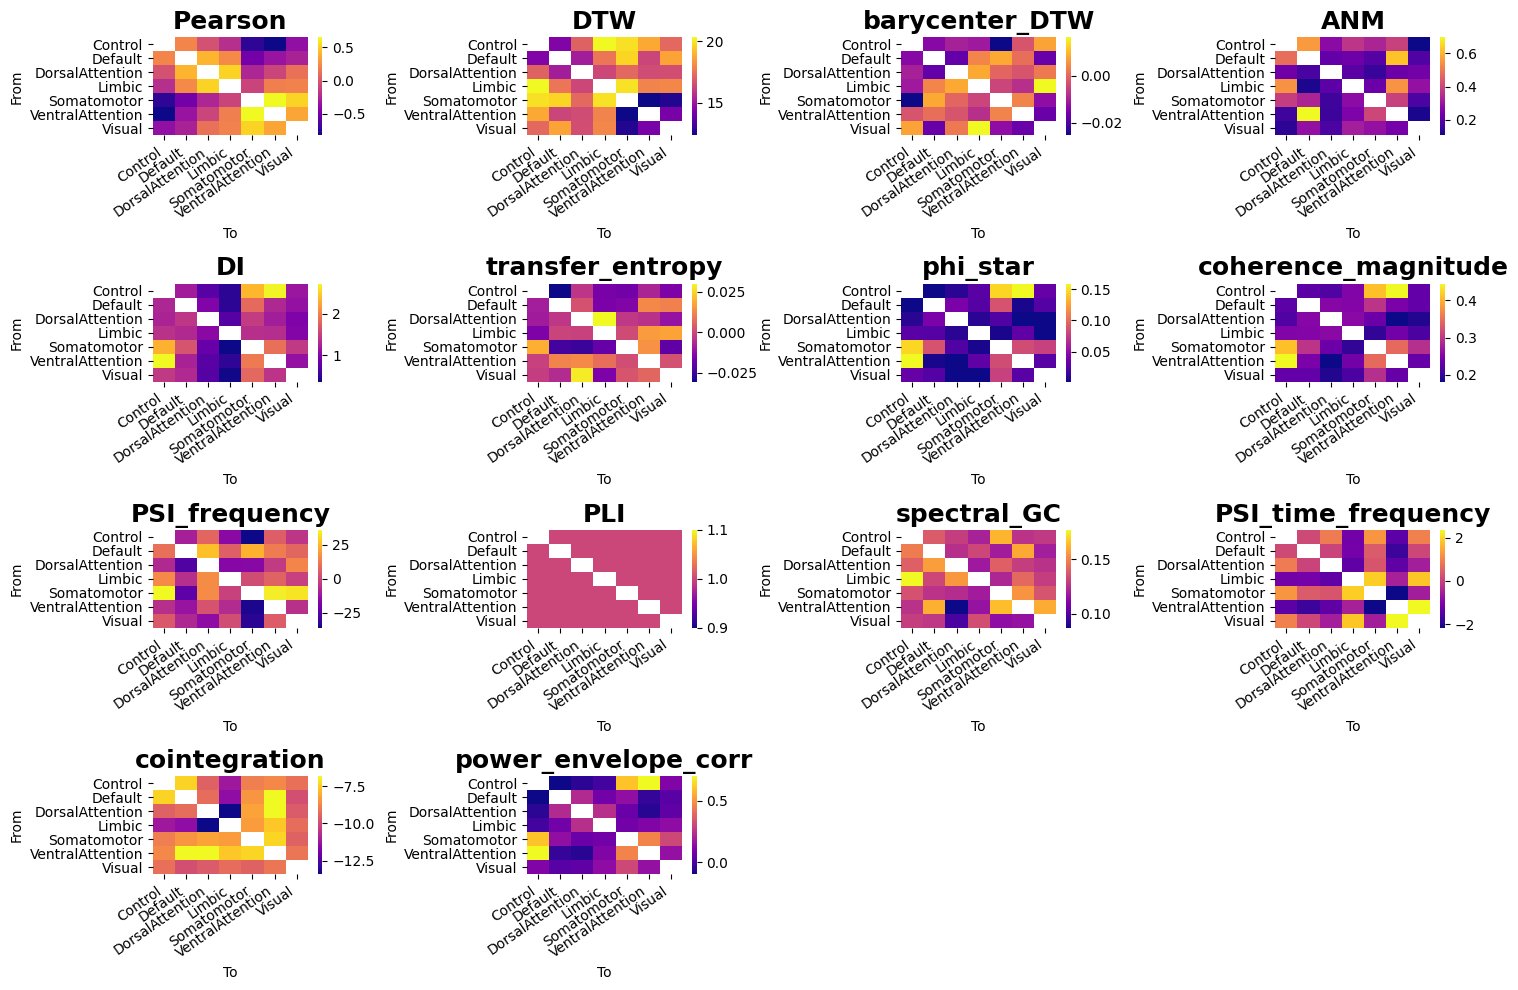

In [12]:
SPI_plot_list = []
fig, axes = plt.subplots(4, 4, figsize=(15, 10))

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Loop through each subplot and add your data
for i, ax in enumerate(axes):
    if i < len(pyspi_results_df['Figure_name'].unique()):
        SPI_name = pyspi_results_df['Figure_name'].unique().tolist()[i]
        SPI_data = pyspi_results_df.query('Figure_name==@SPI_name')
        SPI_data_wide = SPI_data.filter(['Network_From', 'Network_To', 'value']).pivot('Network_From', 'Network_To', 'value')

        # Create heatmap
        sns.heatmap(SPI_data_wide, cmap='plasma', ax=ax)

        # # Remove legend
        # fig.get_axes()[0].collections[0].colorbar.remove()

        # Set x and y labels
        ax.set_xlabel('To')
        ax.set_ylabel('From')

        # Rotate x-axis labels 45 degrees, but keep them centered
        ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right', fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

        # Set title in bold font
        ax.set_title(SPI_name, fontweight='bold', fontsize=18)

# Remove the last two subplots
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
plt.show()